In [5]:
import sys
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
# root_proj = Path("/Users/yk/Documents/Projects/Pre-PhD")
root_proj = Path("/Users/VERTPOM-UPJV/Documents/Banque_de_l'energie_V2/Data_prediction_K/Pre-PhD")
if str(root_proj/"src") not in sys.path:
    sys.path.append(str(root_proj/"src"))

In [6]:
year = 2022
file_name = root_proj / f"DATA_SYSTEM_LIDL/DTS_LIDL_{year}.csv"
dts = pd.read_csv(file_name, sep=";")
dts

,Date,PV,EV
0,1/01/2022 1:00,0.0,0.68
1,1/01/2022 1:15,0.0,0.08
2,1/01/2022 1:30,0.0,0.08
3,1/01/2022 1:45,0.0,0.08
4,1/01/2022 2:00,0.0,0.08
...,...,...,...
34940,31/12/2022 0:00,0.0,0.12
34941,31/12/2022 0:15,0.0,0.08
34942,31/12/2022 0:30,0.0,0.08
34943,31/12/2022 0:45,0.0,0.08


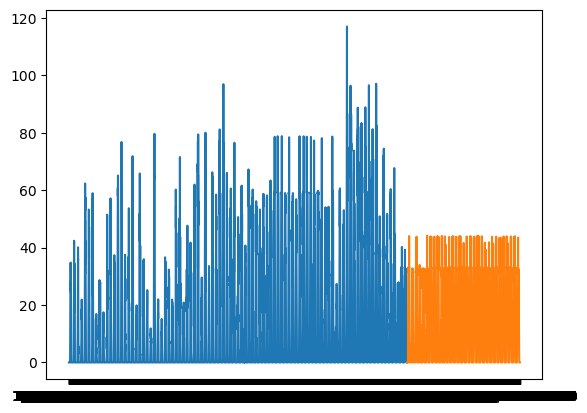

In [8]:
initial = dts.index[dts['Date'] == '4/04/2022 1:00'][0]
final = dts.index[dts['Date'] == '5/05/2022 1:00'][0]

df_train = dts.iloc[:initial]
df_test = dts.iloc[initial:final]
plt.plot(df_train.Date,df_train['PV'], label='Train')
plt.plot(df_test.Date,df_test['PV'], label='Test')

In [19]:
from skforecast.recursive import ForecasterRecursive
from skforecast.preprocessing import RollingFeatures
from sklearn.ensemble import RandomForestRegressor

forecaster = ForecasterRecursive(
    regressor = RandomForestRegressor(random_state=42),
    lags = int((60/15)*24*7), # use previous one day
    window_features = RollingFeatures(stats=['mean'], window_sizes=int((60/15)*24))
)

C:\Users\VERTPOM-UPJV\AppData\Local\Temp\ipykernel_50964\3333954176.py:5: FutureWarning: The `regressor` argument is deprecated and will be removed in a future version. Please use `estimator` instead.
  forecaster = ForecasterRecursive(


In [20]:
import joblib as jb
import json

output_dir = root_proj / "checkpoints" / "point02_pv"

if not (output_dir / "log_pv.json").is_file(): # first train
    output_dir.mkdir(parents=True, exist_ok=True)
    # training
    forecaster.fit(y=df_train['PV'], store_in_sample_residuals=True)
    # residuals = forecaster.in_sample_residuals  # 查看训练残差
    # save model
    jb.dump(forecaster, output_dir/"model.joblib")
    # log
    log = {
        "metadata": {
            "description": "recursive random forest regresion",
            "lags": int((60/15)*24*7),
            "window_features": {
                "type": "rolling",
                "stats": ["mean"],
                "window_size": int((60/15)*24)
            },
            "freq": "15min"
        },
        # "residuals": forecaster.in_sample_residuals
    }
    # save log
    with open(output_dir/"log.json", "w") as f:
        json.dump(log, f, indent=2)
    print("End of training")
else:
    # 加载模型 | load model
    forecaster = jb.load(output_dir/"model.joblib")
    # load log
    with open(output_dir/"log.json", "r") as f:
        log = json.load(f)
    print("Loaded")

End of training


In [21]:
yhat_test = forecaster.predict(steps=len(df_test))

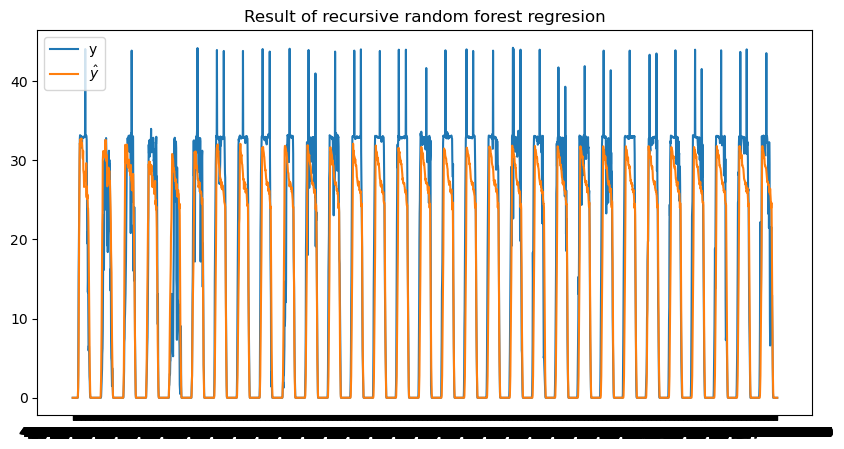

In [22]:
# Save and display the plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Result of recursive random forest regresion")
# ax.plot(df_train['Date'],df_train['PV'])
ax.plot(df_test['Date'], df_test['PV'], label='y')
ax.plot(df_test['Date'], yhat_test, label=r'$\hat{y}$')

ax.legend()

# fig.autofmt_xdate() # for rotation
# fig.savefig(output_dir / "prediction_test.png", dpi=300, bbox_inches='tight')
plt.show()